# Prueba de conceptos

En este vamos a hacer una pruenba con 2 imagenes (Una por delante y la otra por detras), para demostrar los conceptos que usaremos en la implementacion.

## vamos a importar las imagenes

In [111]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import sklearn

(np.float64(-0.5), np.float64(3595.5), np.float64(2539.5), np.float64(-0.5))

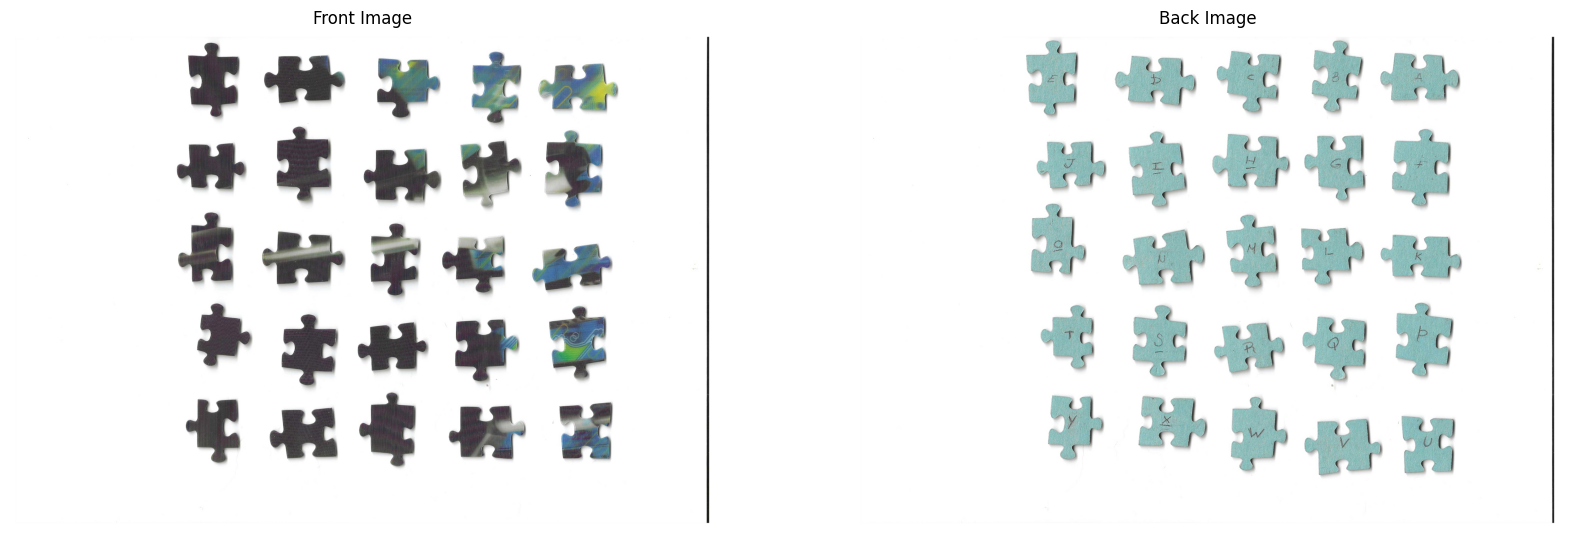

In [112]:
path = 'fotos/scan_25/'

front = cv.imread(path + 'front.jpg')
front = cv.rotate( front, cv.ROTATE_90_CLOCKWISE )
front = cv.copyMakeBorder(front, 30, 30, 30, 30, cv.BORDER_CONSTANT, value=[255, 255, 255])

back = cv.imread(path + 'back.jpg')
back = cv.rotate( back, cv.ROTATE_90_CLOCKWISE )
back = cv.copyMakeBorder(back, 30, 30, 30, 30, cv.BORDER_CONSTANT, value=[255, 255, 255])

front_gray = cv.cvtColor(front, cv.COLOR_BGR2GRAY)
back_gray = cv.cvtColor(back, cv.COLOR_BGR2GRAY)

fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].imshow(cv.cvtColor(front, cv.COLOR_BGR2RGB))
axes[0].set_title('Front Image')
axes[0].axis('off')
axes[1].imshow(cv.cvtColor(back, cv.COLOR_BGR2RGB))
axes[1].set_title('Back Image')
axes[1].axis('off')

## Segmentacion de las piezas

Como el fondo es banco uniforme, podemos usar un thresshold binario para segmentar las piezas del fondo, lo haremos con las piezas delanteras y traseras por separado.

(np.float64(-0.5), np.float64(3595.5), np.float64(2539.5), np.float64(-0.5))

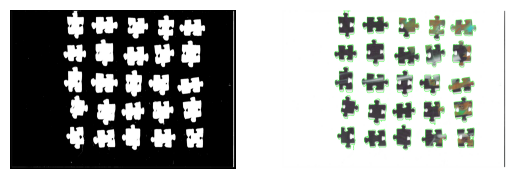

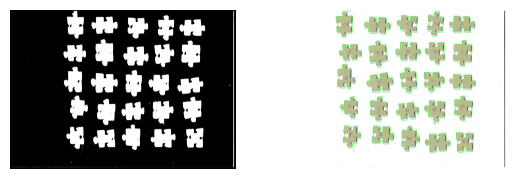

In [113]:
front_thresh = cv.threshold(front_gray, 250, 255, cv.THRESH_BINARY_INV)[1]
back_thresh = cv.threshold(back_gray, 250, 255, cv.THRESH_BINARY_INV)[1]

fig, ax = plt.subplots(1, 2)

plt.sca(ax[0])
plt.imshow(front_thresh, cmap='gray')
plt.axis('off')

front_contours , _ = cv.findContours(front_thresh, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
front_contours = sorted(front_contours, key=cv.contourArea, reverse=True)[:25]
front_segmented = front.copy()
contornos_in_original = cv.drawContours(front_segmented, front_contours, -1, (0, 255, 0), 3)

plt.sca(ax[1])
plt.imshow(contornos_in_original)
plt.axis('off')

fig, ax = plt.subplots(1, 2)

plt.sca(ax[0])
plt.imshow(front_thresh, cmap='gray')
plt.axis('off')

back_contours , _ = cv.findContours(back_thresh, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
back_contours = sorted(back_contours, key=cv.contourArea, reverse=True)[:25]
back_segmented = back.copy()
contornos_in_original = cv.drawContours(back_segmented, back_contours, -1, (0, 255, 0), 3)

plt.sca(ax[1])
plt.imshow(contornos_in_original)
plt.axis('off')

Como queremos guardar una asociacion entre piezas deleanteras y traseras vamos a reordenar las piezas segun su posicion asumineto que en las fotos estan formando una cuadricula 5 x 5.

In [ ]:
def sort_contours(contours, imagen, ax = None):

    if ax != None:
        plt.sca(ax)
        plt.grid("off")

    ordered_contours = []


    centroids = np.array([np.mean(c.reshape(-1, 2), axis=0) for c in contours])
    x_centroids = centroids[:, 0]
    y_centroids = centroids[:, 1]

    # Hacemos un clustering para agrupar las coordenadas en 5 grupos
    x_prediction = sklearn.cluster.KMeans(n_clusters=5, random_state=0).fit(x_centroids.reshape(-1, 1))
    y_prediction = sklearn.cluster.KMeans(n_clusters=5, random_state=0).fit(y_centroids.reshape(-1, 1))

    # ploteamos la regilla generada para comprobar que es correcta
    plt.imshow(imagen)
    

    for i in range(5):
        plt.axvline(x=np.mean(x_centroids[x_prediction.labels_ == i]), color='black', linestyle='--')
        plt.axhline(y=np.mean(y_centroids[y_prediction.labels_ == i]), color='black', linestyle='--')

    plt.scatter(x_centroids, y_centroids, c=y_prediction.labels_ * 5, cmap='tab20')

    plt.title('Clustering de centroides')
    plt.xlabel('Coordenada X')
    plt.ylabel('Coordenada Y')
    plt.grid()

    cluster_centers_x = sorted(list(enumerate(x_prediction.cluster_centers_.flatten())), key=lambda x: x[1])
    cluster_centers_y = sorted(list(enumerate(y_prediction.cluster_centers_.flatten())), key=lambda x: x[1])

    for i, y_center in cluster_centers_y:
        for j, x_center in cluster_centers_x:
            index = np.where((y_prediction.labels_ == i) & (x_prediction.labels_ == j))[0][0]
            centroid = centroids[index]
            ordered_contours.append(contours[index])
            plt.text(centroid[0], centroid[1], f'{len(ordered_contours)}', color='red', fontsize=12)
    
    return ordered_contours

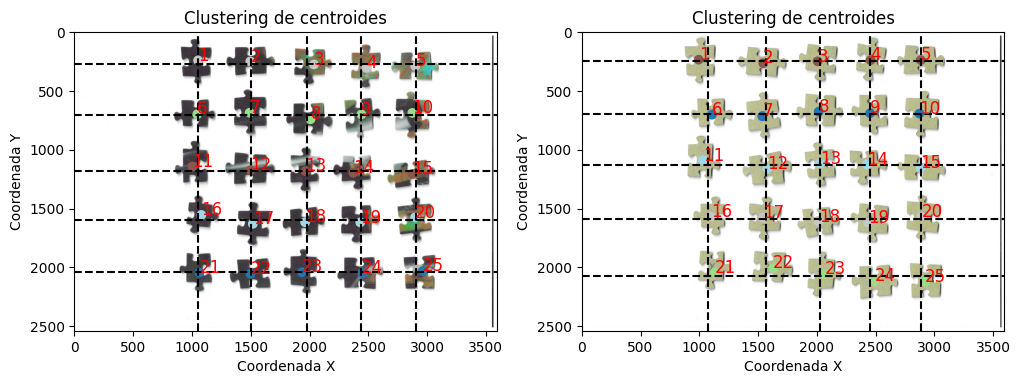

In [115]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes = axes.flatten()

front_contours = sort_contours(front_contours, front, ax=axes[0])
back_contours = sort_contours(back_contours, back, ax=axes[1])

comprobamos que ahora el orden nos crea una asociacion correcta entre piezas delanteras y traseras.

A continuacino generamos los ROIS

In [116]:
front_rois = []

for contorno in front_contours:

    center = np.mean(contorno, axis=0).astype(int)
    max_x = np.max(contorno[:, 0, 0])
    min_x = np.min(contorno[:, 0, 0])
    max_y = np.max(contorno[:, 0, 1])
    min_y = np.min(contorno[:, 0, 1])

    pad = 20

    roi_front = front[min_y - pad:max_y + pad, min_x - pad:max_x + pad]
    front_rois.append(roi_front)

back_rois = []

for contorno in back_contours:

    center = np.mean(contorno, axis=0).astype(int)
    max_x = np.max(contorno[:, 0, 0])
    min_x = np.min(contorno[:, 0, 0])
    max_y = np.max(contorno[:, 0, 1])
    min_y = np.min(contorno[:, 0, 1])

    pad = 20

    roi_back = back[min_y - pad:max_y + pad, min_x - pad:max_x + pad]
    back_rois.append(roi_back)

Comprobamos que los ROIS son correctos

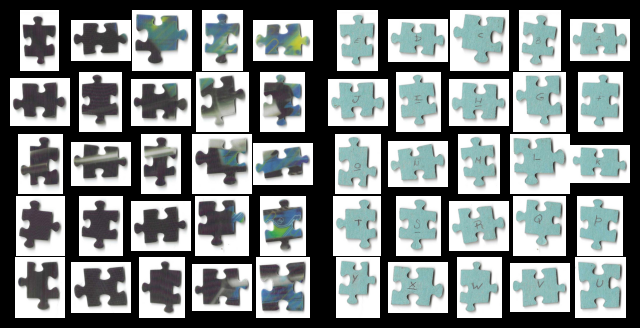

In [117]:
import matplotlib.gridspec as gridspec


fig = plt.figure(figsize=(8, 4), facecolor='black')

outer_gs = gridspec.GridSpec(1, 2, wspace=0.05)

left_gs = gridspec.GridSpecFromSubplotSpec(
    5, 5, subplot_spec=outer_gs[0], wspace=0.02, hspace=0.02
)

for i in range(25):
    ax = fig.add_subplot(left_gs[i])
    ax.imshow(cv.cvtColor(front_rois[i], cv.COLOR_BGR2RGB))
    ax.axis('off')


right_gs = gridspec.GridSpecFromSubplotSpec(
    5, 5, subplot_spec=outer_gs[1], wspace=0.02, hspace=0.02
)

for i in range(25):
    ax = fig.add_subplot(right_gs[i])
    ax.imshow(cv.cvtColor(back_rois[i], cv.COLOR_BGR2RGB))
    ax.axis('off')

plt.show()

Una vez comprobado que los rois son correctos vamos a guardarlos enumerados en una carpeta.

In [118]:
for i, roi in enumerate(front_rois):
    cv.imwrite(f'fotos/segmented_scan_25/front/{i:02d}.png', roi)

for i, roi in enumerate(back_rois):
    cv.imwrite(f'fotos/segmented_scan_25/back/{i:02d}.png', roi)

# Deteccion de aristas y esquinas

vamos a tomar una sola pieza (vista desde atras) para hacer la deteccion de aristas y esquinas.

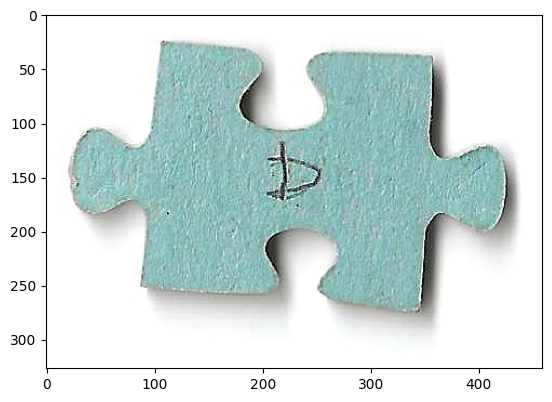

In [152]:
sample_piece = back_rois[1]
plt.imshow(cv.cvtColor(sample_piece, cv.COLOR_BGR2RGB))

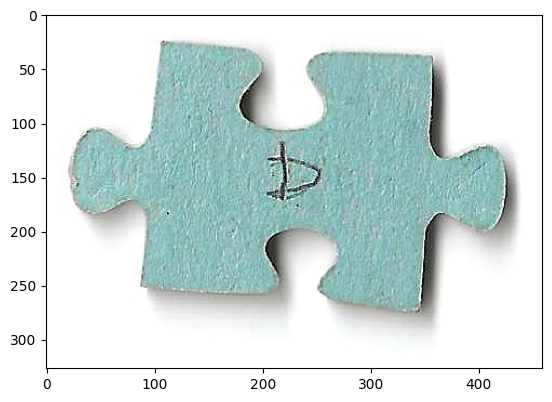

In [153]:
blurred = cv.medianBlur(sample_piece, 1)
plt.imshow(cv.cvtColor(blurred, cv.COLOR_BGR2RGB))

## THRESHOLDING

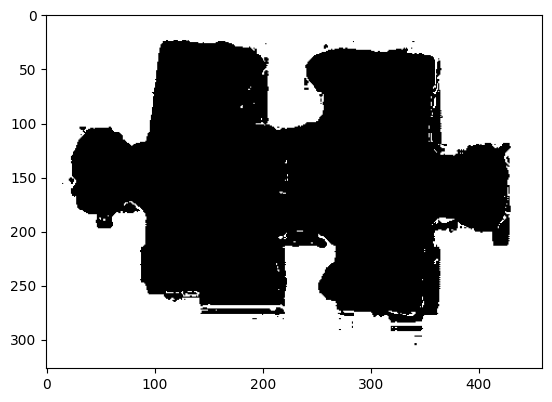

In [156]:
blurred_hsv = cv.cvtColor(blurred, cv.COLOR_BGR2HSV)

# enmascaramos los valores ocn saturacion muy bajos para ver si son la sombre

mask = cv.inRange(blurred_hsv, (0, 0, 0), (180, 5, 255))
plt.imshow(mask, cmap='gray')

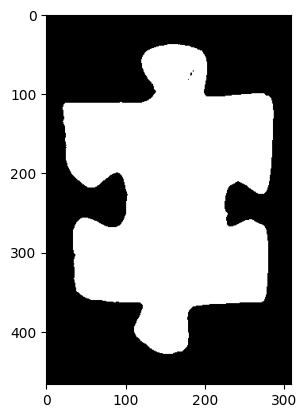

In [145]:
# aplicamos un kmeans con cv

criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 10, 1.0)
blurred_reshaped = blurred.reshape((-1, 3)).astype(np.float32)
_, labels, centers = cv.kmeans(blurred_reshaped, 2, None, criteria, 10, cv.KMEANS_RANDOM_CENTERS)

plt.imshow(labels.reshape(blurred.shape[:2]), cmap='gray')

## CANNY

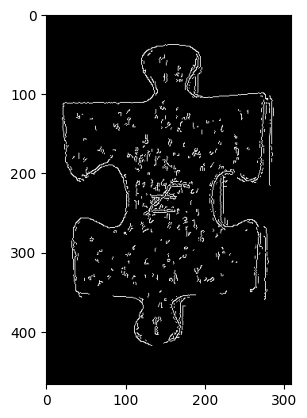

In [130]:
edges = cv.Canny(blurred, 100, 150)
plt.imshow(edges, cmap='gray')